## TRAPPIST-1e effect of degrading to JWST NIRSpec/PRISM
**Author: Nestor Espinoza | Date: March, 2025**

Motivation of this notebook: want to know how much does it matter if we model terrestrial exoplanet spectra at R = 500 or R = 10,000 in light of JWST/NIRSpec PRISM native (pixel) resolution.

# 1. Introductory work

First, define libraries:


In [1]:
import os
import pickle
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
sns.set_style('ticks')

import h5py
import netCDF4 as nc

import matplotlib as mpl 

from scipy.ndimage import gaussian_filter, median_filter
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
from pandeia.engine.instrument_factory import InstrumentFactory

In [3]:
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, compute_spectrum
from POSEIDON.constants import R_Sun, R_E, M_E 

[rakisduam:08844] shmem: mmap: an error occurred while determining whether or not /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T//ompi.rakisduam.2477/jf.0/729546752/sm_segment.rakisduam.2477.2b7c0000.0 could be created.


In [4]:
# Define star/planet atmospheric properties:
star_properties = {}

# From Berger+2018
star_properties['R'] = 0.11697
star_properties['Teff'] = 2559.0
star_properties['FeH'] = 0.04
star_properties['logg'] = 5.21

planet_properties = {}

planet_properties['R'] = 0.917985 # Rearth
planet_properties['M'] = 0.6356 # obtained with spright
planet_properties['T_eq'] = 255 # K 

# Atmosphere is hydrogen-dominated by default:
bulk_species = ['H2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = ['CO2', 'CH4', 'H2O', 'N2', 'O2', 'O3', 'N2O', 'CO'] 

# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

In [5]:
class generate_atmosphere:

    def set_parameters(self, T, log_X, cloud_parameters, P_ref = None):

        if P_ref is None:

            P_ref = self.P_ref

        self.T = T
        self.log_X = log_X
        self.cloud_parameters = cloud_parameters

        PT_params = np.array([T])

        self.atmosphere = make_atmosphere(self.planet, self.model, self.P, P_ref, self.R_p_ref,
                                          PT_params, log_X,  cloud_params=cloud_parameters)

    def get_spectrum(self):

        return compute_spectrum(self.planet, self.star, self.model, self.atmosphere, self.opac, self.wl,
                                spectrum_type = 'transmission')

    def __init__(self, star_properties, planet_properties, param_species, bulk_species,
                 PT_profile = 'isotherm', cloud_model = 'MacMad17', cloud_type = 'deck_haze', cloud_dim = 1,
                 P_min = 1e-7, P_max = 100, N_layers = 100, P_surf = 100.0, wl_min = 0.5, wl_max = 5.7, R = 10000,
                 planet_name = 'myplanet', model_name = 'mymodel'):

        # Load stellar properties:
        self.R_s = star_properties['R'] * R_Sun
        self.T_s = star_properties['Teff']
        self.Met_s = star_properties['FeH']
        self.log_g_s = star_properties['logg']

        # Load planet properties:
        self.R_p = planet_properties['R'] * R_E
        self.M_p = planet_properties['M'] * M_E
        self.T_eq = planet_properties['T_eq']

        # Save parameters for posteriety:
        self.param_species = param_species
        self.bulk_species = bulk_species

        # Create star and planet:
        self.star = create_star(self.R_s, self.T_s, self.log_g_s, self.Met_s)
        self.planet = create_planet(planet_name, self.R_p, mass = self.M_p, T_eq = self.T_eq)


        self.model = define_model(model_name, bulk_species, param_species,
                                  PT_profile = PT_profile,
                                  cloud_model = cloud_model,
                                  cloud_type = cloud_type,
                                  cloud_dim = cloud_dim)

        self.wl = wl_grid_constant_R(wl_min, wl_max, R)

        # Read opacity:
        opacity_treatment = 'opacity_sampling'

        # Define fine temperature grid (K)
        T_fine_min = 100     # 100 K lower limit covers the TRAPPIST-1e P-T profile
        T_fine_max = 300     # 300 K upper limit covers the TRAPPIST-1e P-T profile
        T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

        T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

        # Define fine pressure grid (log10(P/bar))
        log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
        log_P_fine_max = 2.0    # 1 bar is the surface pressure, so no need to go deeper
        log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

        log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step)

        self.opac = read_opacities(self.model, self.wl, opacity_treatment, T_fine, log_P_fine)#, opacity_database = 'Temperate')

        # Set atmosphere --- first, set initial values:
        self.P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)
        self.P_ref = P_surf
        self.R_p_ref = self.R_p

        T_init = 300.
        # this sets by hand the number of opacities --- FIXME to generalize inputs:
        log_X_init = np.log10( np.random.uniform(0, 1, len(param_species) ) )
        a, Pcloud = 1., 1e6
        log_a, gamma, log_P_cloud = np.log10(a), -4., np.log10(Pcloud)
        self.log_a, self.gamma, self.log_P_cloud = np.log10(a), -4., np.log10(Pcloud)

        cloud_params_init = [self.log_a, self.gamma, self.log_P_cloud]

        self.set_parameters(T_init, log_X_init, cloud_params_init)

In [6]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-CH4 done
CO2-H2 done
N2-H2 done
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
CO2 done
CH4 done
H2O done
O2 done
O3 done
N2O done
CO done
Opacity pre-interpolation complete.


In [7]:
# Taken from best-fit:
pressure, CO2, CH4, H2O, N2, O2, O3, N2O, CO = 0.001,\
                                               1.69467002312003e-08,\
                                               0.11770273994234982,\
                                               1.984679393934162e-08,\
                                               9.746997621190566e-05,\
                                               0.00010885455877830879,\
                                               1.7456034892946846e-06,\
                                               8.572845654947684e-05,\
                                               5.575966562339465e-06

T = 203. 
logPcloud, logP_ref = np.log10(0.0014177622911658676), np.log10(0.009836123150223128)
log_X = np.log10( np.array([CO2, CH4, H2O, N2, O2, O3, N2O, CO]) )
P_ref = 10**(logP_ref)
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
model_10barclouds = planet.get_spectrum() * 1e6
filtered_model_10barclouds = gaussian_filter( model_10barclouds, 5)

In [8]:
palette = sns.color_palette("Paired")
sns.set_palette(palette) 

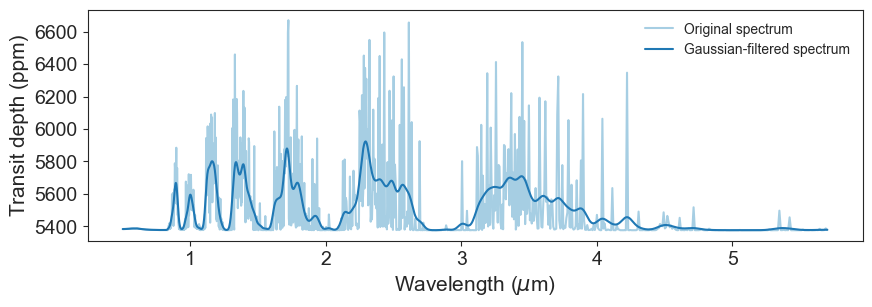

In [9]:
plt.figure(figsize=(10,3))

plt.plot(wavelengths_model, model_10barclouds, label = 'Original spectrum')
plt.plot(wavelengths_model, filtered_model_10barclouds, label = 'Gaussian-filtered spectrum')

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend(frameon=False)

What about a Venus-like atmosphere?

In [10]:
# Atmosphere is hydrogen-dominated by default:
bulk_species = ['CO2']                                      # For terrestrial planets, only the single most abundant gas should be provided here
param_species = ['N2', 'O2', 'CH4', 'H2O', 'O3', 'N2O'] 

# Haze properties fixed:
log_a, gamma = np.log10(1.), -4

In [11]:
N2 = 3.5/100
H2O = 20*1e-6
O2 = 1*1e-9
CH4 = 1*1e-9
O3 = 1*1e-9
N2O = 1*1e-9

In [12]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 500)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
CO2 done
O2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


In [13]:
T = 250. 
logPcloud, logP_ref = 1., 2.
log_X = np.log10( np.array([N2,O2,CH4,H2O,O3,N2O]) )
P_ref = 10**(logP_ref)
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_10barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_10barclouds = gaussian_filter(median_filter(venus_model_10barclouds,10), 2)

In [14]:
# Models with 0.1 bar clouds:
logPcloud = 0
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_1barclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

In [15]:
# Models with 0.1 bar clouds:
logPcloud = -1
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_01barclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

In [16]:
# Models with 0.1 bar clouds:
logPcloud = -6
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_1barclouds = planet.get_spectrum() * 1e6
venus_filtered_model_0001mbarbarclouds = gaussian_filter(median_filter(venus_model_1barclouds,10), 2)

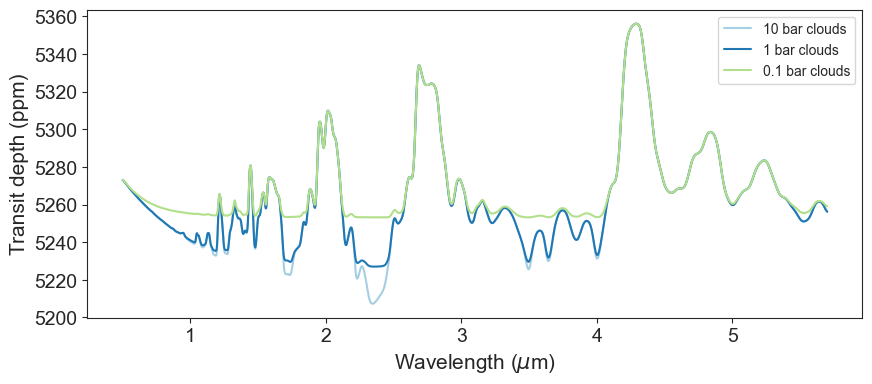

In [17]:
plt.figure(figsize=(10,4))


plt.plot(wavelengths_model, venus_filtered_model_10barclouds, label = '10 bar clouds')
plt.plot(wavelengths_model, venus_filtered_model_1barclouds, label = '1 bar clouds')
plt.plot(wavelengths_model, venus_filtered_model_01barclouds, label = '0.1 bar clouds')

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

# 2. Let's run with R = 10,000

Does the spectrum change much if we up the resolution to, say, R = 10,000?

In [18]:
wavelengths_modelR500 = wl_grid_constant_R(0.5, 5.7, 500)

In [19]:
planet = generate_atmosphere(star_properties, planet_properties, param_species, bulk_species, R = 10000)
wavelengths_model = planet.wl

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
CO2 done
O2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


In [20]:
T = 250. 
logPcloud, logP_ref = 1., 2.
log_X = np.log10( np.array([N2,O2,CH4,H2O,O3,N2O]) )
P_ref = 10**(logP_ref)
planet.set_parameters(T, log_X, [log_a, gamma, logPcloud], P_ref = P_ref)
venus_model_10barcloudsR10000 = planet.get_spectrum() * 1e6
venus_filtered_model_10barcloudsR10000 = gaussian_filter(median_filter(venus_model_10barcloudsR10000,200), 20)

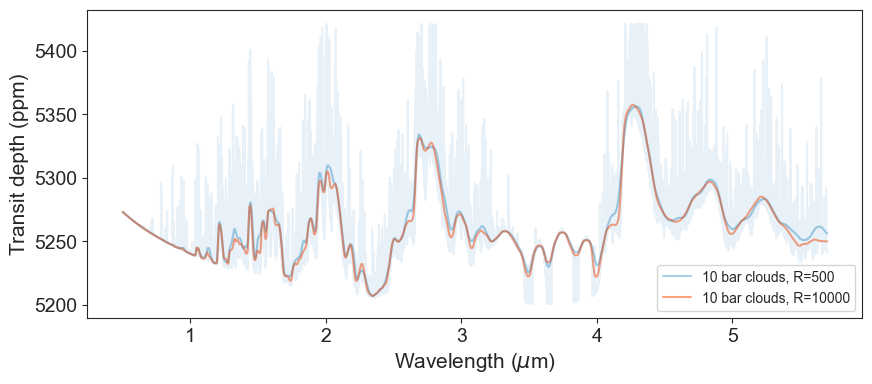

In [21]:
plt.figure(figsize=(10,4))


plt.plot(wavelengths_modelR500, venus_filtered_model_10barclouds, label = '10 bar clouds, R=500')
plt.plot(wavelengths_model, venus_filtered_model_10barcloudsR10000, label = '10 bar clouds, R=10000', color = 'orangered', alpha = 0.5)
plt.plot(wavelengths_model, venus_model_10barcloudsR10000, alpha = 0.1)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

In [22]:
np.sum(venus_filtered_model_10barclouds), np.sum(venus_filtered_model_10barcloudsR10000)

(6399913.558290032, 127938430.39971918)

Just a bit. Note we changed the filter parameters by a factor of 20 (10,000 / 500).

# 3. Using POSEIDON's binning routines

Let's use POSEIDON's binning routines next. First, create some "fake data" to try the model. Let's do this by sampling every 10 datapoints from the original binning:

In [23]:
wl_data = wavelengths_model[::10][10:-10]

In [24]:
half_bins = np.zeros(len(wl_data))

for i in range(len(wl_data)):

    if i == 0:
        
        half_bins[i] = ( wl_data[i+1] - wl_data[i] ) / 2.

    else:

        half_bins[i] = ( wl_data[i] - wl_data[i-1] ) / 2.

Initialize instrument functions. Only need to do this once:

In [25]:
from POSEIDON.core import init_instrument

In [26]:
psf_sigma, fwhm, sens, bin_left, \
           bin_cent, bin_right, norm = init_instrument(wavelengths_model, 
                                                       wl_data, 
                                                       half_bins, 
                                                       'JWST_NIRSpec_PRISM')

In [27]:
from POSEIDON.instrument import make_model_data

Now generate the degraded/binned model:

In [28]:
ymodel = make_model_data(venus_model_10barcloudsR10000, wavelengths_model, 
                         psf_sigma,
                         sens,
                         bin_left,
                         bin_cent,
                         bin_right,
                         norm
                        )

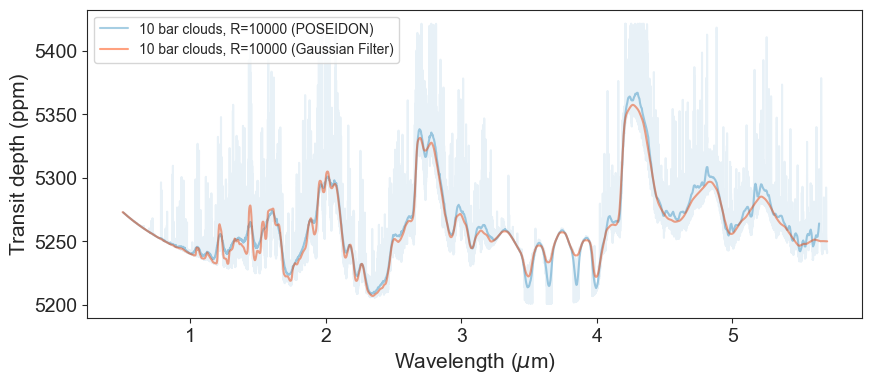

In [29]:
plt.figure(figsize=(10,4))


plt.plot(wl_data, ymodel, label = '10 bar clouds, R=10000 (POSEIDON)')
plt.plot(wavelengths_model, venus_filtered_model_10barcloudsR10000, label = '10 bar clouds, R=10000 (Gaussian Filter)', color = 'orangered', alpha = 0.5)
plt.plot(wavelengths_model, venus_model_10barcloudsR10000, alpha = 0.1)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

What if you bin in large bins?

In [31]:
wl_data2 = np.array([1.,2.,3.,4.,5])
half_bins2 = np.array([0.1,0.1,0.1,0.1,0.1])

In [32]:
psf_sigma2, fwhm2, sens2, bin_left2, \
           bin_cent2, bin_right2, norm2 = init_instrument(wavelengths_model, 
                                                          wl_data2, 
                                                          half_bins2, 
                                                          'JWST_NIRSpec_PRISM')

In [33]:
ymodel2 = make_model_data(venus_model_10barcloudsR10000, wavelengths_model, 
                         psf_sigma2,
                         sens2,
                         bin_left2,
                         bin_cent2,
                         bin_right2,
                         norm2
                        )

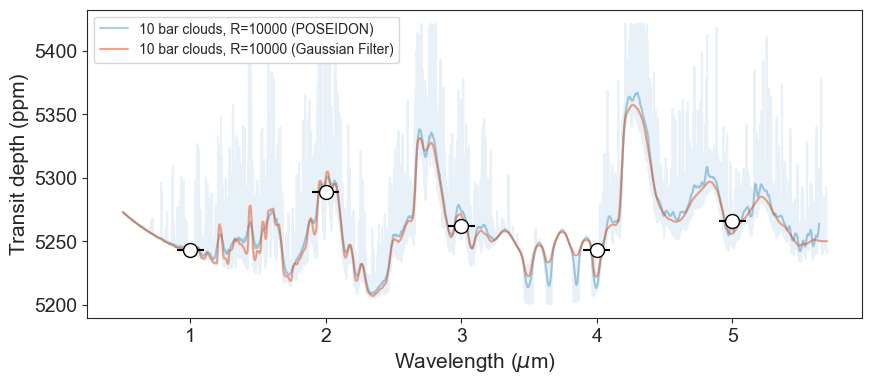

In [40]:
plt.figure(figsize=(10,4))


plt.plot(wl_data, ymodel, label = '10 bar clouds, R=10000 (POSEIDON)')
plt.plot(wavelengths_model, venus_filtered_model_10barcloudsR10000, label = '10 bar clouds, R=10000 (Gaussian Filter)', color = 'orangered', alpha = 0.5)
plt.plot(wavelengths_model, venus_model_10barcloudsR10000, alpha = 0.1)
plt.errorbar(wl_data2, ymodel2, xerr = half_bins2, ecolor = 'black', fmt = 'o', mfc = 'white', mec = 'black', ms = 10)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Wavelength ($\mu$m)',fontsize = 15)
plt.ylabel('Transit depth (ppm)',fontsize = 15)
plt.legend()

The last function is what POSEIDON calls all the time. So we can easily implement this!